In [1]:
import smogn
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import copy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.decomposition import NMF
from sklearn.ensemble import RandomForestRegressor
import subprocess
from sklearn.model_selection import RandomizedSearchCV
import sys
import math
import scipy.spatial.distance
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.tree import DecisionTreeRegressor
import os
import shutil
import glob
import shap
from sklearn.model_selection import train_test_split

cmap='viridis'
sys.path.insert(1, '../')
from LibHelperFuncs import *

rstate = 0
np.random.seed(rstate)
njob = -1

from sklearn.neural_network import MLPRegressor

C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tommy\AppData\Roaming\Python\Python37\site-

In [2]:
originalDat = np.genfromtxt("../../Data/data_bas_preprocessing.csv", delimiter=',')
originalDat_pd = pd.read_csv("../../Data/data_bas_preprocessing_pd.csv")

X = originalDat[:,:-1]
Y = originalDat[:,-1]
C = originalDat_pd.columns


In [3]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8 ), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True).fit(X, Y)

In [4]:
rrows = np.random.randint(0, X.shape[0], size=100)

Xsub = X[rrows,:]

In [5]:
mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8 ), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True).fit(X, Y)

exp = shap.Explainer(mlp.predict, Xsub)
s_vals = exp(Xsub)
ov_shap = np.mean(np.abs(s_vals.values), axis=0)

Permutation explainer: 101it [08:00,  4.76s/it]                                                                        


In [6]:
pca = PCA(n_components=50)
pca.fit(X)
comps = pca.components_
X_r = (comps @ X.T).T
Xr_sub = X_r[rrows,:]

mlp = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True).fit(X_r, Y)

expr = shap.Explainer(mlp.predict, Xr_sub)
s_valsr = expr(Xr_sub)
ov_reduced_shap = mean_carried_shap(s_valsr.values, pca.components_, np.zeros((100, 390)))

Permutation explainer: 101it [00:42,  2.35it/s]                                                                        


In [7]:
urscorecv=[]
rscorecv=[]
urscorel2=[]
rscorel2=[]

renge = range(1, X.shape[1])

for k in renge:
    if k % 10 == 0:
        print(k)
    X_l = X[:,np.argsort(ov_shap)[::-1][:k]]

    rf = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True)

    rf.fit(X_l, Y)
    urscorel2.append(model_eval(X_l, Y, rf, rstate=rstate))
    urscorecv.append(model_crosseval(X_l, Y, rf))

    X_r = X[:,np.argsort(ov_reduced_shap)[::-1][:k]]

    rf = MLPRegressor(hidden_layer_sizes=(128, 64, 32, 8), random_state=rstate, max_iter=2000, learning_rate='adaptive', shuffle=True)

    rf.fit(X_r, Y)
    rscorel2.append(model_eval(X_r, Y, rf, rstate=rstate))
    rscorecv.append(model_crosseval(X_r, Y, rf))

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380


0.002295960708695731 0.0020959238963496594
0.06470245828535198 0.06476067759140096


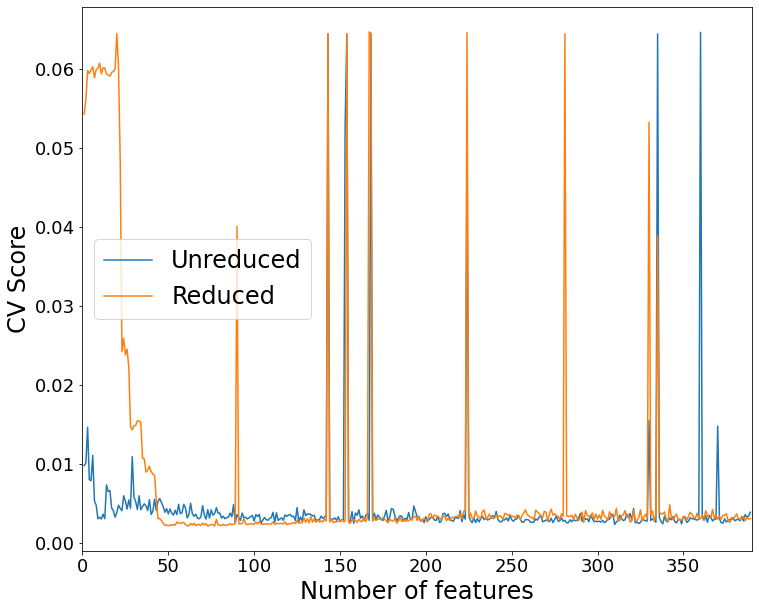

In [13]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorecv, label = 'Unreduced')
plt.plot(renge, rscorecv, label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("CV Score", fontsize=24)

plt.xlim([0, X.shape[1]])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorecv), min(rscorecv))
print(max(urscorecv), max(rscorecv))

plt.savefig("../../Figures/LRA_MLP_CV_full.pdf", bbox_inches='tight')

0.046614240624433055 0.04313657134415505
0.2401467565526142 0.24053334991462677


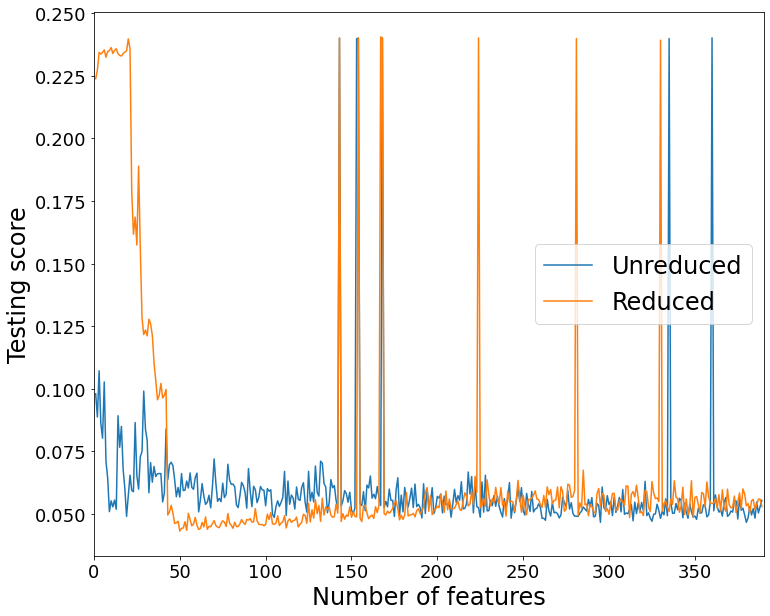

In [12]:
plt.figure(figsize=(12,10))

plt.plot(renge, urscorel2, label = 'Unreduced')
plt.plot(renge, rscorel2, label='Reduced')

plt.xlabel('Number of features', fontsize=24)
plt.ylabel("Testing score", fontsize=24)

plt.xlim([0, X.shape[1]])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=24)

print(min(urscorel2), min(rscorel2))
print(max(urscorel2), max(rscorel2))

plt.savefig("../../Figures/LRA_MLP_testing_full.pdf", bbox_inches='tight')